In [1]:
import sys
sys.path.append("../")
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 16.0) 

## black level estimation

In [2]:
# rIm=read_raw("../static_videos/lowlight_frame47_rg10.raw", frame = 47)
# print(rIm.shape, rIm.dtype)
bk_lvl = 50 #int(rIm[0].mean())
print("black level of the sensor: ", bk_lvl)

black level of the sensor:  50


## low light single frame demosaicking

### video: 8 frames with tremor motion
### reference frame: 1st frame

In [3]:
rIm=read_raw("../static_videos/lowlight3_frame16_bunny.raw", frame = 8)
rIm = rIm[:, :2048, :3584]
ref_idx = 0
rIm_single = rIm[ref_idx] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)

rIm_single shape:  (2048, 3584) dtype: int16
rIm_single stat: max: 28, min: 0, mean: 7.266927719116211, std: 3.4986172052474522
bit_length 4.807355


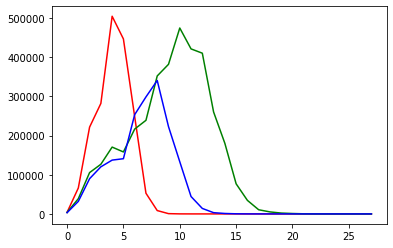

In [4]:
plot_histogram(rIm_single, bit_length)

In [5]:
# rgbIm_single = demosaic(rIm_single)

In [6]:
# rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
# fig, ax = plt.subplots(1, 2, figsize=(20, 16))
# ax[0].imshow(rIm_single)
# ax[1].imshow(rgbIm_adj_single)
# plt.show()

## simple summationand and demosaicking

In [7]:
rIm_sum = rIm.sum(axis = 0) - bk_lvl* rIm.shape[0]
print_stat("rIm_sum", rIm_sum)
bit_length = np.log2(rIm_sum.max())
print("bit_length", bit_length)

rIm_sum shape:  (2048, 3584) dtype: int64
rIm_sum stat: max: 223, min: 2, mean: 58.13256195613316, std: 26.948871686757702
bit_length 7.800899899920305


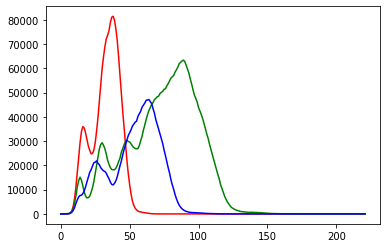

In [8]:
plot_histogram(rIm_sum, bit_length)

In [9]:
rIm_sum = np.clip(rIm_sum, 0, 1023)

In [10]:
# rgbIm = demosaic(rIm_sum)

In [11]:
# rgbIm_adj = adjustColor(rgbIm,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)

In [12]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 16))
# ax[0].imshow(rIm_sum)
# ax[1].imshow(rgbIm_adj)
# plt.show()

## Align & merge in Google's paper and demosaicking

In [13]:
from hdrplus import HDRPlus_model

In [14]:
final0 = HDRPlus_model(rIm[:8])

merging 2th alternative frame
merging 3th alternative frame
merging 4th alternative frame
merging 5th alternative frame
merging 6th alternative frame
merging 7th alternative frame
merging 8th alternative frame


In [15]:
from merge_utils import *
from align_utils import *
import time

In [16]:
tic = time.time()
final = rIm[ref_idx].copy().astype(np.float64)
for idx in range(0, 8):
    print("current idx:", idx)
    if idx == ref_idx:
        continue
    ref = rIm[ref_idx]
    alt = rIm[idx]
    ### modified 09/24/20 for integrated HDR+ merge ###
    ###-----------before-------------##
    #final_align_field = np.load('final_align_field_ref{}_{}.npy'.format(ref_idx,idx))
    ### ----------after -------------##
    gray_ref, gray_alt = downsample2x2(ref), downsample2x2(alt)
    gpref, gpalt = gauss_pyramid(gray_ref, 4, [2, 4, 4]), gauss_pyramid(gray_alt, 4, [2, 4, 4])
    final_align_field = align_gauss_pyramid_hdrplus(gpref, gpalt)
    upsampled_align_field = upsample_align_field(final_align_field, 2)
    bi_align_field = bilateral_upsample(upsampled_align_field)
    merged_frame = merge(ref, alt, bi_align_field, 16, 8)
    final += merged_frame
print("time elapsed: ", time.time()-tic)

current idx: 0
current idx: 1
current idx: 2
current idx: 3
current idx: 4
current idx: 5
current idx: 6
current idx: 7
time elapsed:  98.18342614173889


In [17]:
np.sum((final - final0)**2)

0.0

In [15]:
rIm_merge = final[32:-32, 32:-32] - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge shape:  (1984, 3520) dtype: int16
rIm_merge stat: max: 223, min: -4, mean: 57.84809627588893, std: 27.31451288405381
bit_length 7.8009


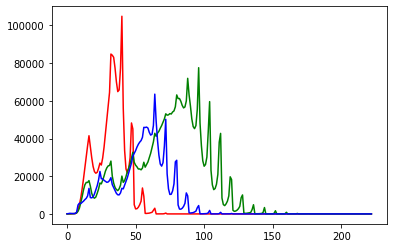

In [16]:
plot_histogram(rIm_merge, bit_length)

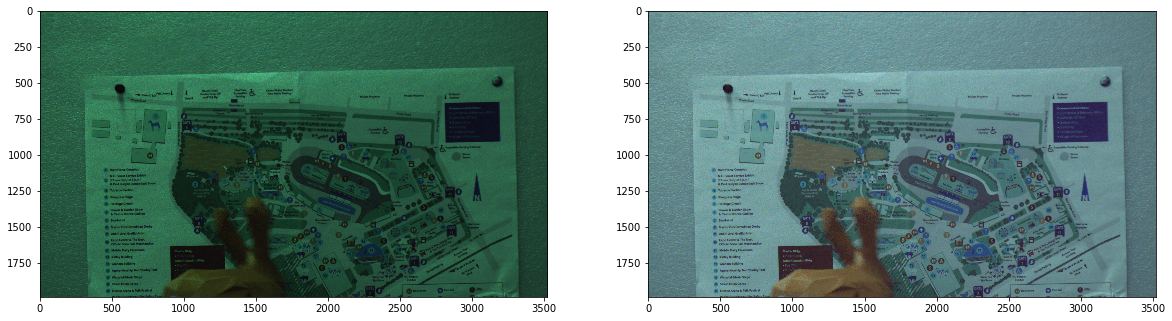

In [17]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rgbIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

In [18]:
# cv2.imwrite("rgbIm_adj_merge_ref{}.png".format(ref_idx), rgbIm_adj_merge[..., ::-1])
# cv2.imwrite("rgbIm_adj_ref{}.png".format(ref_idx), rgbIm_adj[32:-32, 32:-32, ::-1])
# cv2.imwrite("rgbIm_adj_single_ref{}.png".format(ref_idx), rgbIm_adj_single[32:-32, 32:-32, ::-1])

In [19]:
# rgbIm_adj = cv2.imread("rgbIm_adj_ref{}.png".format(ref_idx))[..., ::-1]
# rgbIm_adj_single = cv2.imread("rgbIm_adj_single_ref{}.png".format(ref_idx))[..., ::-1]
# rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge_ref{}.png".format(ref_idx))[..., ::-1]

# fig, ax = plt.subplots(2, 3, figsize=(20, 16))
# ax[0][0].imshow(rgbIm_adj_merge[1700:1828, 1020:1148])
# ax[0][1].imshow(rgbIm_adj[1700:1828, 1020:1148])
# ax[0][2].imshow(rgbIm_adj_single[1700:1828, 1020:1148])
# ax[1][0].imshow(rgbIm_adj_merge[1600:1728, 1500:1628])
# ax[1][1].imshow(rgbIm_adj[1600:1728, 1500:1628])
# ax[1][2].imshow(rgbIm_adj_single[1600:1728, 1500:1628])
# plt.show()